In [3]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from mesh import *
import time
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.tri as tri
from sklearn.metrics import mean_absolute_percentage_error as mbpe

In [12]:
def analytic_sol(L: float, g1: float, g2: float) -> float:

    dxdy_inc = 1.e-4 # m
    num_inc  = int(L/dxdy_inc)
    x        = np.linspace(0,L,num_inc)
    y        = np.linspace(0,L,num_inc)
    xv, yv   = np.meshgrid(x,y)
    beta     = np.zeros([num_inc,num_inc])
    beta_one = np.ones([num_inc,num_inc])
    
    for n in range(1,200):
        term1 = (2/np.pi)*((-1)**(n+1)+1)/n
        beta = beta + term1*np.sin(n*np.pi*xv/L)*np.cosh(n*np.pi*yv/L)/np.cosh(n*np.pi)

    temp = (g2-g1)*beta + g1*beta_one

    return xv, yv, temp

def analytic_sol_v(xv, yv, L: float, g1: float, g2: float) -> float:

    beta     = np.zeros([len(xv)])
    beta_one = np.ones([len(xv)])
    
    for n in range(1,200):
        term1 = (2/np.pi)*((-1)**(n+1)+1)/n
        beta = beta + term1*np.sin(n*np.pi*xv/L)*np.cosh(n*np.pi*yv/L)/np.cosh(n*np.pi)

    temp = (g2-g1)*beta + g1*beta_one

    return xv, yv, temp

def analytic_sol_xy(x, y, L: float, g1: float, g2: float) -> float:
 
    beta = 0
    for n in range(1,200):
        term1 = (2/np.pi)*((-1)**(n+1)+1)/n
        beta = beta + term1*np.sin(n*np.pi*x/L)*np.cosh(n*np.pi*y/L)/np.cosh(n*np.pi)

    temp = (g2-g1)*beta + g1
    return temp


def el_conductivity_quad(coordsx,D):
    # nodal coordinates of element in local node numbering
    x1 = coordsx[0]
    x2 = coordsx[1]
    x3 = coordsx[2]
    x4 = coordsx[3]
    y1 = coordsx[4]
    y2 = coordsx[5]
    y3 = coordsx[6]
    y4 = coordsx[7]
    
    # initialize matrix
    k_e = np.zeros([4,4])
    
    # initialize
    xi_vect = np.zeros([4,2])
    weight  = np.zeros([4,1])
    
    # set Gauss point coordinates in xi, eta, zeta space
    const        = 1/np.sqrt(3)
    xi_vect[0,:] = np.array([-const, -const])
    xi_vect[1,:] = np.array([ const, -const])
    xi_vect[2,:] = np.array([ const,  const])
    xi_vect[3,:] = np.array([-const,  const])
    
    # set weights
    weight[0] = 1
    weight[1] = 1
    weight[2] = 1
    weight[3] = 1
    
    #print(f'D = {D}')
    
    # loop through Gauss points
    for ip in range(0,4):
        # current Gauss pt location
        xi   = xi_vect[ip,0]
        eta  = xi_vect[ip,1]
        
        # derivatives of shape functions with respect to xi
        dN1_dxi = -0.25*(1-eta)
        dN2_dxi = 0.25*(1-eta)
        dN3_dxi = 0.25*(eta+1)
        dN4_dxi = -0.25*(eta+1)

        # derivatives of shape functions with respect to eta
        dN1_deta = -0.25*(1-xi)
        dN2_deta = -0.25*(xi+1)
        dN3_deta = 0.25*(xi+1)
        dN4_deta = 0.25*(1-xi)

        # calculate jacobian, its determinant, and its inverse
        dx_dxi   = dN1_dxi*x1 + dN2_dxi*x2 + dN3_dxi*x3 + dN4_dxi*x4
        dx_deta  = dN1_deta*x1 + dN2_deta*x2 + dN3_deta*x3 + dN4_deta*x4
        dy_dxi   = dN1_dxi*y1 + dN2_dxi*y2 + dN3_dxi*y3 + dN4_dxi*y4
        dy_deta  = dN1_deta*y1 + dN2_deta*y2 + dN3_deta*y3 + dN4_deta*y4
        Je = np.array([ [dx_dxi, dx_deta], \
                        [dy_dxi, dy_deta] ])
        je    = np.linalg.det(Je)
        Jeinv = np.linalg.inv(Je)
        
        dN1_dx_vect = np.dot( np.array([dN1_dxi, dN1_deta]), Jeinv )
        dN2_dx_vect = np.dot( np.array([dN2_dxi, dN2_deta]), Jeinv )
        dN3_dx_vect = np.dot( np.array([dN3_dxi, dN3_deta]), Jeinv )
        dN4_dx_vect = np.dot( np.array([dN4_dxi, dN4_deta]), Jeinv )
        
        B1 = np.array([ dN1_dx_vect[0], dN1_dx_vect[1] ])
        B2 = np.array([ dN2_dx_vect[0], dN2_dx_vect[1] ])
        B3 = np.array([ dN3_dx_vect[0], dN3_dx_vect[1] ])
        B4 = np.array([ dN4_dx_vect[0], dN4_dx_vect[1] ])
        
        B = np.transpose(np.block([ [B1], [B2], [B3], [B4] ]))
        
        #print(B.shape)
        #print(f'B = {B}')
        
        k_e = k_e + je*weight[ip]*np.dot( np.transpose(B), np.dot(D, B) )
        #print(k_e.shape)
        #print(f'k_e = {k_e}')
        
        # end for loop over ips
    
    return k_e



def el_flux_bc_quad(coordsx,qflux):
    # nodal coordinates of element in local node numbering
    x1 = coordsx[0]
    x2 = coordsx[1]
    x3 = coordsx[2]
    x4 = coordsx[3]
    y1 = coordsx[4]
    y2 = coordsx[5]
    y3 = coordsx[6]
    y4 = coordsx[7]
    
    # this case assumes integrate flux bc along eta=-1 edge
    eta = -1
    
    # initialize matrix
    flux_bc = np.zeros([4,1])
    
    # initialize
    xi_vect = np.zeros([2,1])
    weight  = np.zeros([2,1])
    
    # set Gauss point coordinates in xi space
    const      = 1/np.sqrt(3)
    xi_vect[0] = -const
    xi_vect[1] = const
    
    # set weights
    weight[0] = 1
    weight[1] = 1
    
    #print(f'D = {D}')
    
    # loop through Gauss points
    for ip in range(0,2):
        # current Gauss pt location
        xi   = xi_vect[ip]
        
        # derivatives of shape functions with respect to xi
        dN1_dxi = -0.25*(1-eta)
        dN2_dxi = 0.25*(1-eta)
        dN3_dxi = 0.25*(eta+1)
        dN4_dxi = -0.25*(eta+1)

        # derivatives of shape functions with respect to eta
        dN1_deta = -0.25*(1-xi)
        dN2_deta = -0.25*(xi+1)
        dN3_deta = 0.25*(xi+1)
        dN4_deta = 0.25*(1-xi)

        # calculate surface jacobian
        dx_dxi   = dN1_dxi*x1 + dN2_dxi*x2 + dN3_dxi*x3 + dN4_dxi*x4
        dx_deta  = dN1_deta*x1 + dN2_deta*x2 + dN3_deta*x3 + dN4_deta*x4
        dy_dxi   = dN1_dxi*y1 + dN2_dxi*y2 + dN3_dxi*y3 + dN4_dxi*y4
        dy_deta  = dN1_deta*y1 + dN2_deta*y2 + dN3_deta*y3 + dN4_deta*y4
        int_map = np.sqrt(dx_dxi*dx_dxi+dy_dxi*dy_dxi)
        
        # shape functions
        N1 = (1-xi)*(1-eta)/4
        N2 = (1+xi)*(1-eta)/4
        N3 = (1+xi)*(1+eta)/4
        N4 = (1-xi)*(1+eta)/4
        N_array = np.array([ N1, N2, N3, N4 ])
        #print(N_array.shape)
        
        flux_bc = flux_bc + np.ndarray.item(weight[ip])*int_map*qflux*N_array
        #print(flux_bc.shape)
        #print(f'flux_bc = {flux_bc}')
        
        # end for loop over ips
    
    return flux_bc

def el_flux_quad(coordsx,D,d):
    # nodal coordinates of elements in local node numbering
    x1 = coordsx[0]
    x2 = coordsx[1]
    x3 = coordsx[2]
    x4 = coordsx[3]
    y1 = coordsx[4]
    y2 = coordsx[5]
    y3 = coordsx[6]
    y4 = coordsx[7]
        
    # initialize at Gauss pts
    flux_el = np.zeros([4,2])
    
    # initialize
    xi_vect = np.zeros([4,2])
    weight  = np.zeros([4,1])
    
    # set Gauss point coordinates in xi, eta, zeta space
    const        = 1/np.sqrt(3)
    xi_vect[0,:] = np.array([-const, -const])
    xi_vect[1,:] = np.array([ const, -const])
    xi_vect[2,:] = np.array([ const,  const])
    xi_vect[3,:] = np.array([-const,  const])
    
    # set weights
    weight[0] = 1
    weight[1] = 1
    weight[2] = 1
    weight[3] = 1
    
    #print(f'D = {D}')
    
    # loop through the Gauss points
    for ip in range(0,4):
        # current Gauss pt location
        xi   = xi_vect[ip,0]
        eta  = xi_vect[ip,1]
        
        # derivatives of shape functions with respect to xi
        dN1_dxi = -0.25*(1-eta)
        dN2_dxi = 0.25*(1-eta)
        dN3_dxi = 0.25*(eta+1)
        dN4_dxi = -0.25*(eta+1)

        # derivatives of shape functions with respect to eta
        dN1_deta = -0.25*(1-xi)
        dN2_deta = -0.25*(xi+1)
        dN3_deta = 0.25*(xi+1)
        dN4_deta = 0.25*(1-xi)

        # calculate jacobian, its determinant, and its inverse
        dx_dxi   = dN1_dxi*x1 + dN2_dxi*x2 + dN3_dxi*x3 + dN4_dxi*x4
        dx_deta  = dN1_deta*x1 + dN2_deta*x2 + dN3_deta*x3 + dN4_deta*x4
        dy_dxi   = dN1_dxi*y1 + dN2_dxi*y2 + dN3_dxi*y3 + dN4_dxi*y4
        dy_deta  = dN1_deta*y1 + dN2_deta*y2 + dN3_deta*y3 + dN4_deta*y4
        Je = np.array([ [dx_dxi, dx_deta], \
                        [dy_dxi, dy_deta] ])
        je    = np.linalg.det(Je)
        Jeinv = np.linalg.inv(Je)
        
        dN1_dx_vect = np.dot( np.array([dN1_dxi, dN1_deta]), Jeinv )
        dN2_dx_vect = np.dot( np.array([dN2_dxi, dN2_deta]), Jeinv )
        dN3_dx_vect = np.dot( np.array([dN3_dxi, dN3_deta]), Jeinv )
        dN4_dx_vect = np.dot( np.array([dN4_dxi, dN4_deta]), Jeinv )
        
        B1 = np.array([ dN1_dx_vect[0], dN1_dx_vect[1] ])
        B2 = np.array([ dN2_dx_vect[0], dN2_dx_vect[1] ])
        B3 = np.array([ dN3_dx_vect[0], dN3_dx_vect[1] ])
        B4 = np.array([ dN4_dx_vect[0], dN4_dx_vect[1] ])
        
        B = np.transpose(np.block([ [B1], [B2], [B3], [B4] ]))

        
        flux_el[ip,:] = -np.dot( D, np.dot(B, d) )

        
    return flux_el

def solve_d(num_el, L, therm_cond, g1, g2):
    
    # isotropic thermal conductivity
    kappa  = therm_cond # W/(m degC)
    D      = kappa * np.array([[1,0],[0,1]])


    nel        = num_el        # number of elements in mesh
    nel_nodes  = 4             # number of nodes per element
    nel_dof    = nel_nodes*1   # number of dof per element
    nsd        = 2             # x,y: number of spatial dimensions
    nel_coords = nel_nodes*nsd # number of element coordinates
    num_ips    = 4             # number of integration points per element
    
    # initialize
    d_el      = np.zeros([nel,nel_dof])
    Kk_el     = np.zeros([nel,nel_dof,nel_dof])
    Fq_el     = np.zeros([nel,nel_dof])
    coords_el = np.zeros([nel,nel_coords])
    LM_el     = np.zeros([nel,nel_dof])
    g_el      = np.zeros([nel,nel_dof])
    flux_el   = np.zeros([nel,num_ips,nsd])
    
    # enter coordinates in coords for each element in this format
    # coords(n,:)=[ x1, x2, x3, x4, y1, y2, y3, y4 ]
    L=0.1
    # 1,2,3,4 refer to the local node numbering
    for i in range(nel):
        coords_el[i,:] = np.array([0, 0.05, 0.05, 0, i*L/nel, i*L/nel, (i+1)*L/nel, (i+1)*L/nel])
        
        if i < nel - 1:
            LM_el[i,:] = np.array([i+1, 0, 0, i+2])
            g_el[i,:] = np.array([0, g1, g1, 0])
        else: 
            LM_el[i,:] = np.array([i+1, 0, 0, 0])
            g_el[i,:] = np.array([0, g1, g1, g2])

    ndof = nel
    K    = np.zeros([ndof,ndof])
    d    = np.zeros([ndof,1])
    F_g  = np.zeros([ndof,1])
    F_q  = np.zeros([ndof,1])            

    for el in range(0,nel):
        Kk_el[el,:,:] = el_conductivity_quad(coords_el[el,:],D)

    for el in range(0,nel):
        temp = LM_el[el,:]

        for i in range(0,nel_dof):
            I = int(temp[i])
            if I > 0:
                for j in range(0,nel_dof):
                    J = int(temp[j])
                    if J > 0:
                        K[I-1,J-1] = K[I-1,J-1] + Kk_el[el,i,j]
                    else:
                        F_g[I-1]   = F_g[I-1] - Kk_el[el,i,j]*g_el[el,j]

    qflux       = 0
    el          = 0

    Fq_el[el,:] = np.ndarray.flatten(el_flux_bc_quad(coords_el[el,:],qflux))
    temp        = LM_el[el,:]
    for i in range(0,nel_dof):
            I = int(temp[i])
            if I > 0:
                F_q[I-1] = F_q[I-1] + Fq_el[el,i]

    F = F_q + F_g

    d = np.linalg.solve(K,F)
    d = np.append(d, 50.0)
    return d

def element_stiffness(node_coords, k):
    B = np.zeros((2, 3))
    A = 0.5 * abs(np.linalg.det(np.array([
        [1, node_coords[0, 0], node_coords[0, 1]],
        [1, node_coords[1, 0], node_coords[1, 1]],
        [1, node_coords[2, 0], node_coords[2, 1]],
    ])))
    for i in range(3):
        j, k = (i + 1) % 3, (i + 2) % 3
        B[0, i] = node_coords[j, 1] - node_coords[k, 1]
        B[1, i] = node_coords[k, 0] - node_coords[j, 0]
    B /= (2 * A)
    K_elem = k * A * (B.T @ B)
    return K_elem

def triangular_mesh(Lx, Ly, nx, ny, k=1):
    
    # make the points for the nodes where we want the triangles to be
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y)
    nodes = np.vstack([X.ravel(), Y.ravel()]).T
    
    #create the geometry of the triangles by connecting the nodes
    triangles = tri.Triangulation(nodes[:, 0], nodes[:, 1]).triangles
    q = 1.0
    
    n_nodes = len(nodes)
    
    #generate k and F - will assemble later
    
    K = lil_matrix((n_nodes, n_nodes))
    F = np.zeros(n_nodes)

    # boundaries - could have been input but am lazy.
    boundary_temps = {
        "left": 20,  
        "right": 20,  
        "top": 50,  
    }
    
    #assemble k, f with boundaries
    for tri_nodes in triangles:
        coords = nodes[tri_nodes]
        K_elem = element_stiffness(coords, k)
        for i in range(3):
            for j in range(3):
                K[tri_nodes[i], tri_nodes[j]] += K_elem[i, j]
            F[tri_nodes[i]] += q * (np.linalg.det(np.array([
                [1, coords[0, 0], coords[0, 1]],
                [1, coords[1, 0], coords[1, 1]],
                [1, coords[2, 0], coords[2, 1]],
            ])) / 6.0)
    
    for i, (x, y) in enumerate(nodes):
        if np.isclose(x, 0):  
            K[i, :] = 0
            K[i, i] = 1
            F[i] = boundary_temps["left"]
        elif np.isclose(x, Lx):  
            K[i, :] = 0
            K[i, i] = 1
            F[i] = boundary_temps["right"]
        elif np.isclose(y, Ly): 
            K[i, :] = 0
            K[i, i] = 1
            F[i] = boundary_temps["top"]

    K = K.tocsr()
    #solve for unknown - this library is more eff than np.
    T = spsolve(K, F)
    
    return T, nodes, triangles

def show_triangle_T(T, nodes):
    
    y = []
    yt = []

    for i in range(len(nodes)):

        if nodes[i][0] == 0.05:

            y.append(nodes[i][1])
            yt.append(T[i])
            
    return y, yt
    

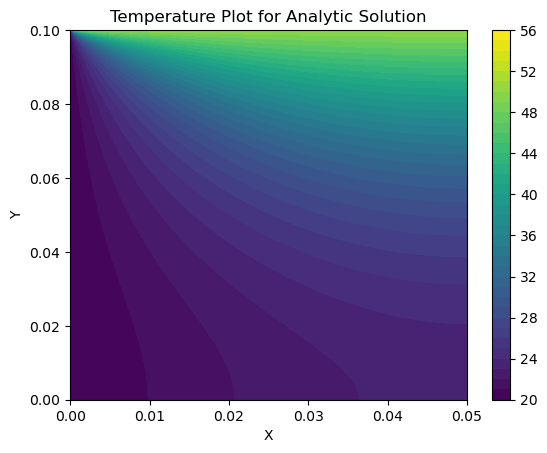

In [5]:
x, y, z = analytic_sol(0.1, 20, 50) 

plt.contourf(x, y, z, levels=40)
plt.colorbar()
plt.title('Temperature Plot for Analytic Solution')
plt.xlim(0., 0.05)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [6]:
# create all the meshes and compute solutions, time

times = []
ds = []
lst = [4, 6, 8, 10]

for i in lst:
    start = time.time()
    
    ds.append(solve_d(i, 0.1, 205, 20, 50))
    
    end = time.time()
    
    times.append(end-start)
    
    

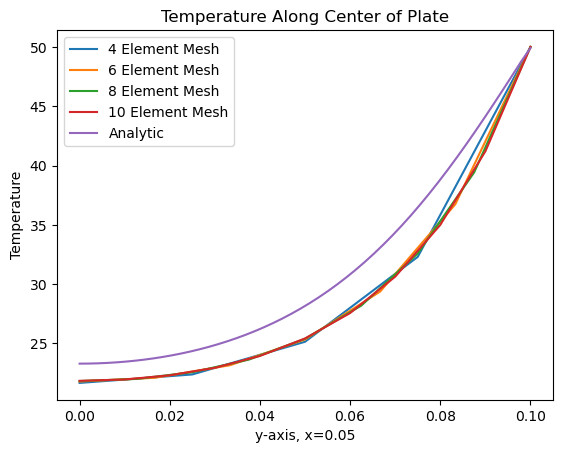

In [7]:
plt.plot([i*0.1/4 for i in range(4)]+[0.1], ds[0], label='4 Element Mesh')
plt.plot([i*0.1/6 for i in range(6)]+[0.1], ds[1], label='6 Element Mesh')
plt.plot([i*0.1/8 for i in range(8)]+[0.1], ds[2], label='8 Element Mesh')

plt.plot([i*0.1/10 for i in range(10)]+[0.1], ds[3], label='10 Element Mesh')

x = np.linspace(0, 0.1, 50)

y = analytic_sol_xy(0.05, x, 0.1, 20, 50)
plt.plot(x, y, label='Analytic')

plt.title("Temperature Along Center of Plate")
plt.xlabel("y-axis, x=0.05")
plt.ylabel("Temperature")
plt.legend()
plt.show()

In [24]:
#lets get percent error

y1 = np.array([i*0.1/4 for i in range(4)]+[0.1])
x1 = np.ones(len(y1))*0.05
t1 = ds[0]

_,_ ,t_true = analytic_sol_v(x1, y1, 0.1, 20, 50)

mbpe(t_true, t1)
print("m1:", mbpe(t_true, t1))

y1 = np.array([i*0.1/6 for i in range(6)]+[0.1])
x1 = np.ones(len(y1))*0.05
t1 = ds[1]

_,_ ,t_true = analytic_sol_v(x1, y1, 0.1, 20, 50)
print("m2:", mbpe(t_true, t1))

y1 = np.array([i*0.1/8 for i in range(8)]+[0.1])
x1 = np.ones(len(y1))*0.05
t1 = ds[2]

_,_ ,t_true = analytic_sol_v(x1, y1, 0.1, 20, 50)
print("m3:", mbpe(t_true, t1))

y1 = np.array([i*0.1/10 for i in range(10)]+[0.1])
x1 = np.ones(len(y1))*0.05
t1 = ds[3]

_,_ ,t_true = analytic_sol_v(x1, y1, 0.1, 20, 50)
print("m4:", mbpe(t_true, t1))

m1: 0.07482437705641326
m2: 0.07492221762277507
m3: 0.07554154971661363
m4: 0.07609417748888157


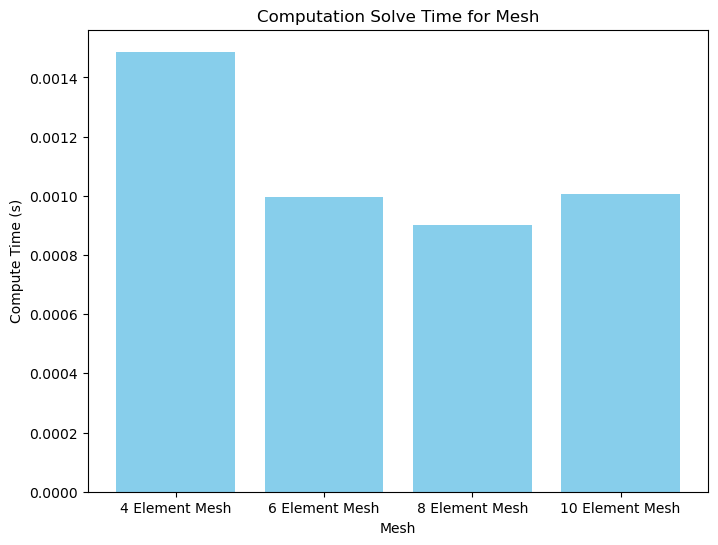

In [6]:
# Example data: Titles and corresponding values
titles = ['4 Element Mesh', '6 Element Mesh', '8 Element Mesh', '10 Element Mesh']
values = times

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(titles, values, color='skyblue')

# Add plot details
plt.title("Computation Solve Time for Mesh")
plt.xlabel("Mesh")
plt.ylabel("Compute Time (s)")

# Show the plot
plt.show()

In [7]:
# create function for triangular elements

In [8]:
T, nodes, triangles = triangular_mesh(0.1, 0.1, 5, 5, k=1)

In [41]:
# create all the meshes and compute solutions, time

times = []
ds = []
lst = [3, 5, 7, 9]

for i in lst:
    start = time.time()
    
    T, nodes, _  = triangular_mesh(0.1, 0.1, i, i, k=1)
    
    ds.append(show_triangle_T(T, nodes))
    
    end = time.time()
    
    times.append(end-start)
    

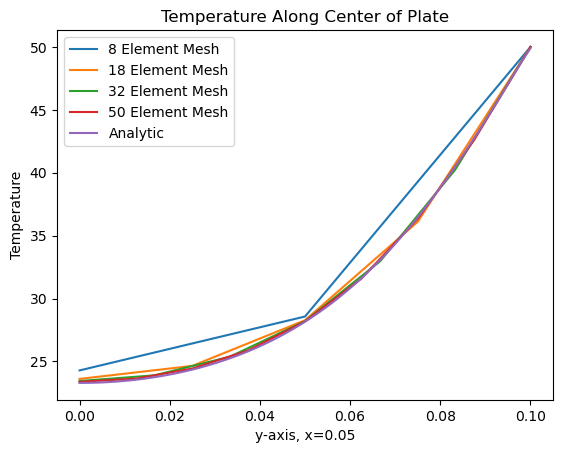

In [42]:
plt.plot(ds[0][0], ds[0][1], label='8 Element Mesh')

plt.plot(ds[1][0], ds[1][1], label='18 Element Mesh')
plt.plot(ds[2][0], ds[2][1], label='32 Element Mesh')

plt.plot(ds[3][0], ds[3][1], label='50 Element Mesh')

x = np.linspace(0, 0.1, 50)

y = analytic_sol_xy(0.05, x, 0.1, 20, 50)
plt.plot(x, y, label='Analytic')

plt.title("Temperature Along Center of Plate")
plt.xlabel("y-axis, x=0.05")
plt.ylabel("Temperature")
plt.legend()
plt.show()

In [43]:
for i in range(4):

    y1 = np.array(ds[i][0])
    x1 = np.ones(len(y1))*0.05
    t1 = ds[i][1]

    _,_ ,t_true = analytic_sol_v(x1, y1, 0.1, 20, 50)
    mbpe(t_true, t1)
    print("m:",i+1, mbpe(t_true, t1))

m: 1 0.01977906803074399
m: 2 0.008347123453737379
m: 3 0.0043944564386431285
m: 4 0.002672701168521982


In [44]:
times

[0.0053937435150146484,
 0.008260011672973633,
 0.011584997177124023,
 0.015060186386108398]

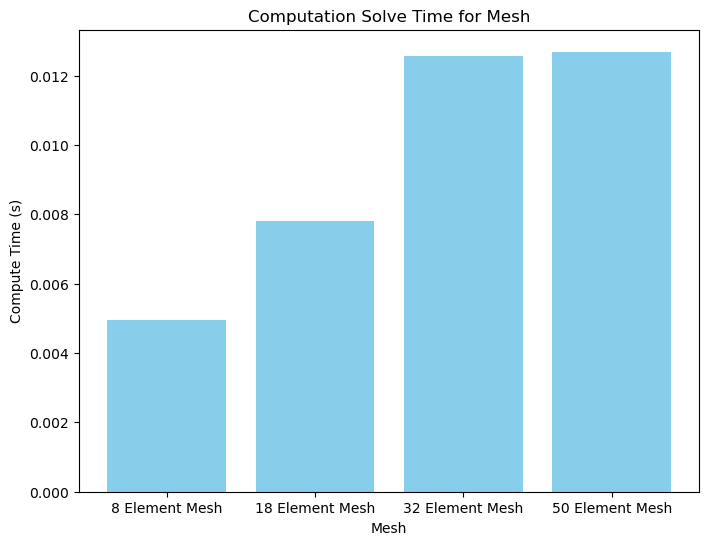

In [39]:
# Example data: Titles and corresponding values
titles = ['8 Element Mesh', '18 Element Mesh', '32 Element Mesh', '50 Element Mesh']
values = times

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(titles, values, color='skyblue')

# Add plot details
plt.title("Computation Solve Time for Mesh")
plt.xlabel("Mesh")
plt.ylabel("Compute Time (s)")

# Show the plot
plt.show()

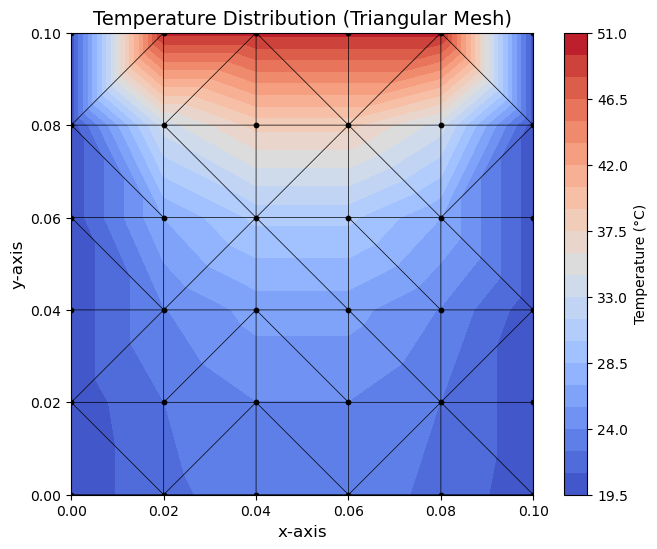

In [13]:
T, nodes, triangles = triangular_mesh(0.1, 0.1, 6, 6, k=1)

# Visualize results
plt.figure(figsize=(8, 6))
plt.tricontourf(nodes[:, 0], nodes[:, 1], triangles, T, levels=20, cmap="coolwarm")
plt.colorbar(label="Temperature (°C)")
plt.triplot(nodes[:, 0], nodes[:, 1], triangles, color="black", linewidth=0.5)
plt.scatter(nodes[:, 0], nodes[:, 1], color="black", s=10)
plt.title("Temperature Distribution (Triangular Mesh)", fontsize=14)
plt.xlabel("x-axis", fontsize=12)
plt.ylabel("y-axis", fontsize=12)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()